In [2]:
import matplotlib.pyplot as plt
from pprint import PrettyPrinter
import pandas as pd
import plotly.express as px
import pytz
from IPython.display import VimeoVideo
from pymongo import MongoClient
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [3]:
# Complete to the create a client to connect to the MongoDB server, assign the "air-quality" 
# database to db, and assign the "nairobi" connection to nairobi.
pp=PrettyPrinter(indent=2) # initiaalize printer so that we can see mongodb databases

# client = MongoClient(host="localhost",port=27017)
# db = client['air-quality']
# nairobi = db['nairobi']

# pythonic code in one line
nairobi=MongoClient(host="localhost",port=27017)['air-quality']['nairobi']
pp.pprint(nairobi.count_documents({}))


202212


In [4]:
# Complete the wrangle function below so that the results from the database query are read into the 
# DataFrame df. Be sure that the index of df is the "timestamp" from the results.
def wrangle(collection):
    results=collection.find(
        {"metadata.site":29, "metadata.measurement":"P2"}
        ,projection={"P2":1,"timestamp":1,"_id":0}
    )

    # Convert the result to DataFrame
    df=pd.DataFrame(results).set_index('timestamp')
    
    # Localize timezone
    df.index=df.index.tz_localize("UTC").tz_convert("Africa/Nairobi")

    # Remove Outliers
    df=df[df['P2']<500]

    # resamble to 1 Hour window, ffill missing values
    df=df['P2'].resample('1H').mean().fillna(method='ffill').to_frame()

    # Add lag feature
    df['P2.L1']=df['P2'].shift(1)

    # drop NaN rows
    df.dropna(inplace=True)
    
    return df

In [5]:
# Use your wrangle function to read the data from the nairobi collection into the DataFrame df.
df=wrangle(nairobi)
df.head(5)

C:\Users\MSI\AppData\Local\Temp\ipykernel_8608\2407599189.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df=df['P2'].resample('1H').mean().fillna(method='ffill').to_frame()
C:\Users\MSI\AppData\Local\Temp\ipykernel_8608\2407599189.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df=df['P2'].resample('1H').mean().fillna(method='ffill').to_frame()


,P2,P2.L1
timestamp,,
2018-11-01 17:00:00+03:00,25.621667,22.170000
2018-11-01 18:00:00+03:00,26.746667,25.621667
2018-11-01 19:00:00+03:00,25.840000,26.746667
2018-11-01 20:00:00+03:00,21.888333,25.840000
2018-11-01 21:00:00+03:00,29.207500,21.888333


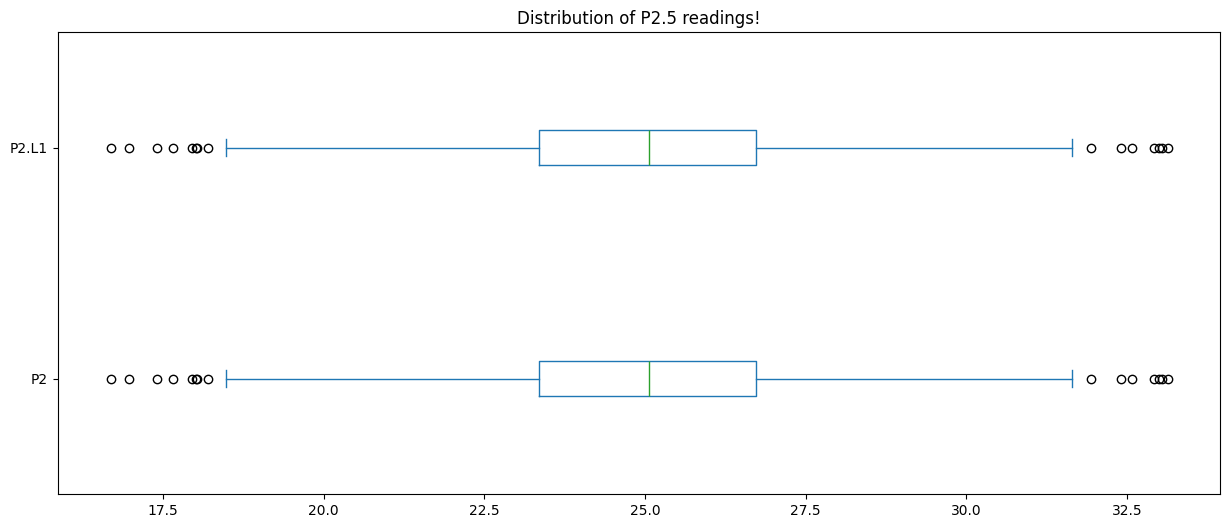

In [54]:
#Create a boxplot of the "P2" readings in df.
fig,ax=plt.subplots(figsize=(15,6))
df.plot(kind='box',vert=False,ax=ax, title="Distribution of P2.5 readings!");

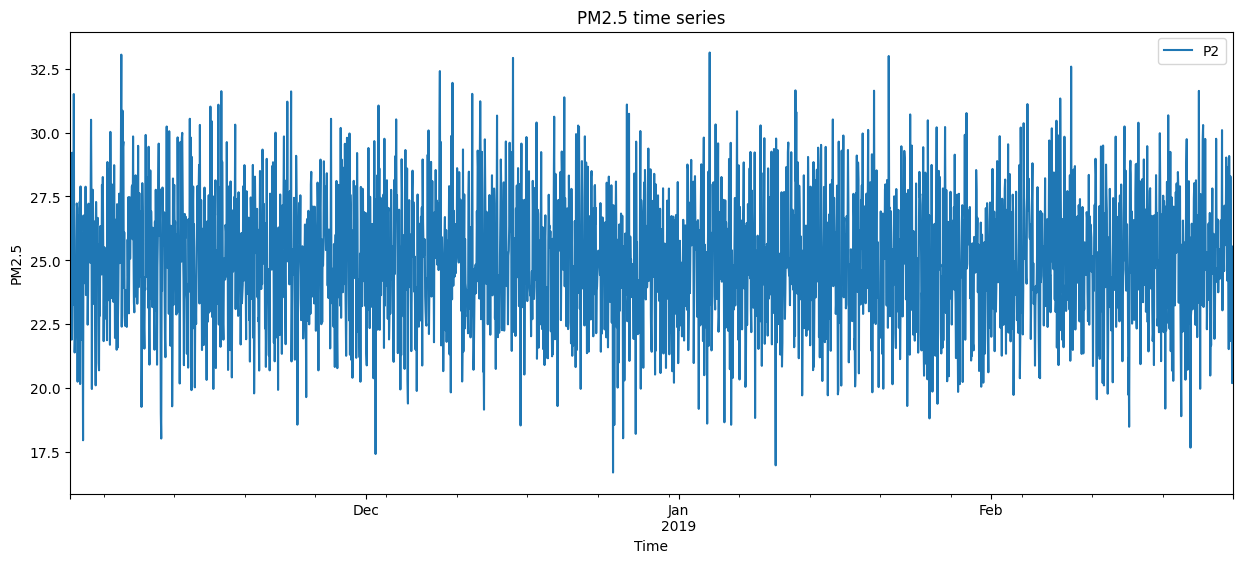

In [34]:
# Create Line plot using Pandas
fig,ax=plt.subplots(figsize=(15,6))
df.plot(xlabel="Time",ylabel="PM2.5",title="PM2.5 time series",ax=ax);

In [6]:
# In this section, Need to do some analysis to see the 1 week moving average.
df['P2'].rolling(168).mean()
# to see how many null values are thare. 
#df['P2'].rolling(168).mean().isnull().sum() 

timestamp
2018-11-01 17:00:00+03:00          NaN
2018-11-01 18:00:00+03:00          NaN
2018-11-01 19:00:00+03:00          NaN
2018-11-01 20:00:00+03:00          NaN
2018-11-01 21:00:00+03:00          NaN
                               ...    
2019-02-24 18:00:00+03:00    25.173105
2019-02-24 19:00:00+03:00    25.169638
2019-02-24 20:00:00+03:00    25.184365
2019-02-24 21:00:00+03:00    25.145074
2019-02-24 22:00:00+03:00    25.143713
Freq: h, Name: P2, Length: 2766, dtype: float64

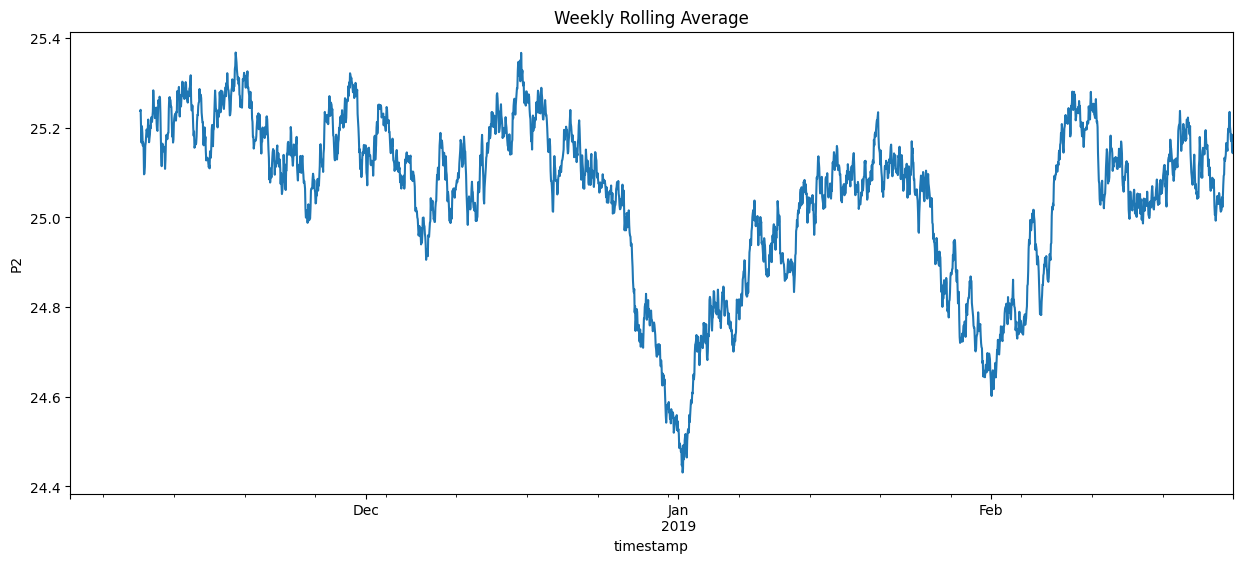

In [7]:
# Plot the rolling average of the "P2" readings in df. Use a window size of 168 (the number of hours in a week).
fig,ax=plt.subplots(figsize=(15,6))
df['P2'].rolling(168).mean().plot(ax=ax,ylabel="P2",title="Weekly Rolling Average");

In [8]:
#Create a correlation matrix for df.
df.corr()

,P2,P2.L1
P2,1.000000,-0.004395
P2.L1,-0.004395,1.000000


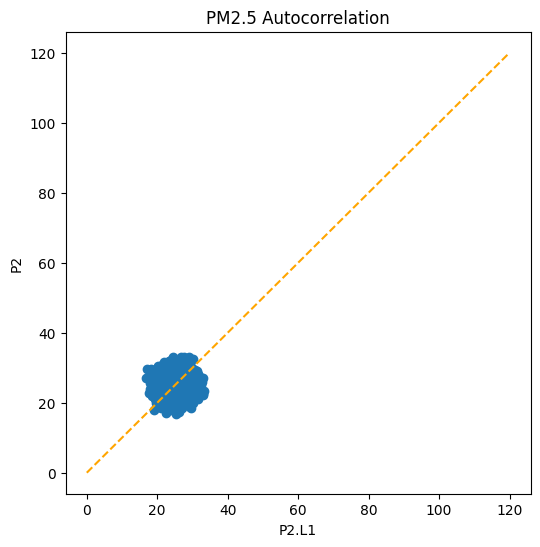

In [9]:
# Create a scatter plot that shows PM 2.5 mean reading for each our as a function of the mean reading from the previous hour. 
# In other words, "P2.L1" should be on the x-axis, and "P2" should be on the y-axis. Don't forget to label your axes!

fig,ax=plt.subplots(figsize=(6,6))
ax.scatter(x=df['P2.L1'],y=df['P2'])
ax.plot([0,120],[0,120],linestyle="--",color="orange")
plt.xlabel("P2.L1")
plt.ylabel("P2")
plt.title("PM2.5 Autocorrelation");

In [11]:
# Split the DataFrame df into the feature matrix X and the target vector y. Your target is "P2".
target="P2"
y=df[target]
X=df.drop(columns="P2")

In [ ]:
#Split X and y into training and test sets. The first 80% of the data should be in your training set. 
# The remaining 20% should be in the test set.
cutoff=int(len(X)*0.8)
len(X.iloc[:cutoff])
X_train,y_train=X.iloc[:cutoff],y.iloc[:cutoff]
X_test,y_test=X.iloc[cutoff:],y.iloc[cutoff:]

In [27]:
# Calculate the baseline mean absolute error for your model.
y_mean=y_train.mean()
y_pred_baseline = [y_mean]*len(y_train)
mae_baseline = mean_absolute_error(y_train,y_pred_baseline)

print("Mean P2 Reading:", round(y_train.mean(), 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean P2 Reading: 25.03
Baseline MAE: 2.01


In [36]:
# Instantiate a LinearRegression model named model, and fit it to your training data.
model =LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [35]:
# Calculate the training and test mean absolute error for your model.

training_mae = mean_absolute_error(y_train,model.predict(X_train))
test_mae = mean_absolute_error(y_test,model.predict(X_test))
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 2.01
Test MAE: 1.94


In [39]:
# Extract the intercept and coefficient from your model.
intercept = round(model.intercept_,2)
coefficient = round(model.coef_[0],2)

print(f"P2 = {intercept} + ({coefficient} * P2.L1)")

P2 = 25.38 + (-0.01 * P2.L1)


In [40]:
# Create a DataFrame df_pred_test that has two columns: "y_test" and "y_pred". 
# The first should contain the true values for your test set, and the second should contain your model's predictions. 
# Be sure the index of df_pred_test matches the index of y_test.

df_pred_test = pd.DataFrame(
    {
        "y_test":y_test
        ,"y_pred":model.predict(X_test)
    }
)
df_pred_test.head()

,y_test,y_pred
timestamp,,
2019-02-01 21:00:00+03:00,23.115833,24.965287
2019-02-01 22:00:00+03:00,22.352500,25.059725
2019-02-01 23:00:00+03:00,25.945833,25.070418
2019-02-02 00:00:00+03:00,24.756667,25.020082
2019-02-02 01:00:00+03:00,21.260000,25.036740


In [42]:
# Create a time series line plot for the values in test_predictions using plotly express. Be sure that the y-axis is properly labeled as "P2".
fig=px.line(df_pred_test,labels={"value":"P2"})
fig.show()